<a href="https://colab.research.google.com/github/arinaaandreeva/HSE_projects/blob/main/%D0%90%D0%BD%D0%B4%D1%80%D0%B5%D0%B5%D0%B2%D0%B0%D0%90%D0%90_%D0%9D%D0%98%D0%A1_%D0%92%D0%B5%D0%B9%D0%B2%D0%BB%D0%B5%D1%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Андреева Арина

**ДЗ по НИСу к 09.10.23**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from scipy.fft import fft
from scipy.fft import fftfreq
import scipy
import seaborn as sns

In [ ]:
df= pd.read_excel('https://github.com/arinaaandreeva/Datasets/raw/main/imoex.xlsx')

In [ ]:
df = df.rename(columns = {'<DATE>' : 'date', '<CLOSE>' : 'imoex'})

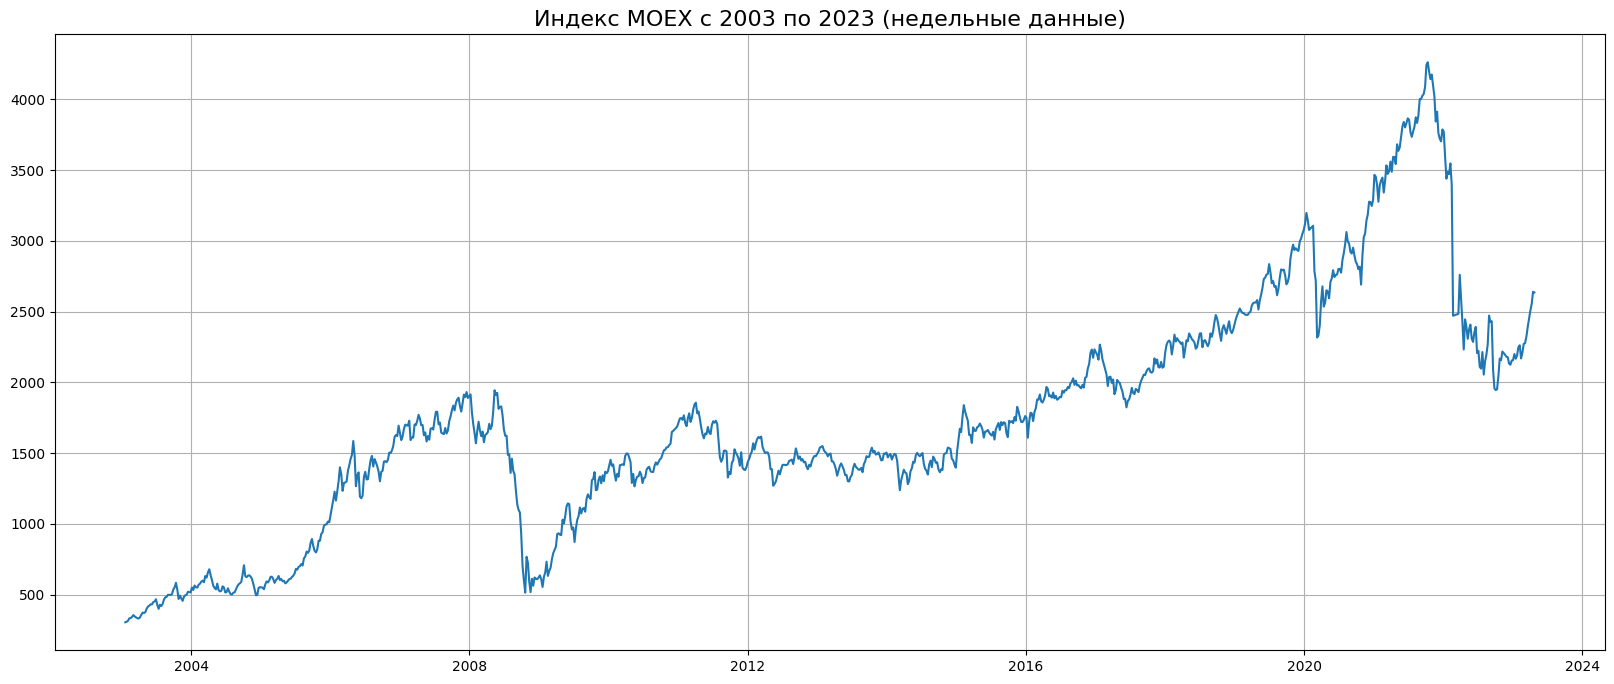

In [ ]:
plt.figure(figsize = (20,8))
plt.grid()

plt.plot(df['date'],
         df['imoex'],
         label = 'индекс московской биржи')

plt.title('Индекс MOEX с 2003 по 2023 (недельные данные)', fontsize = 16);

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
def check_stationarity(data):
  result=adfuller(data)
  if result[1]<0.01:
    print('Ряд стационарный.Отвергаем H0 на уровне знач 0,05.')
  else:
    print('Ряд нестационарный')
  print('adf: ', result[0])
  print(f'p-value {result[1]}')
  print('Critical values: ', result[4])

In [ ]:
imoex = df['imoex']
check_stationarity(df['imoex'])

Ряд нестационарный
adf:  -1.8026863286357138
p-value 0.37912882398435316
Critical values:  {'1%': -3.4367396063176874, '5%': -2.8643611157329905, '10%': -2.5682720836420705}


In [ ]:
df.set_index('date', inplace=True)

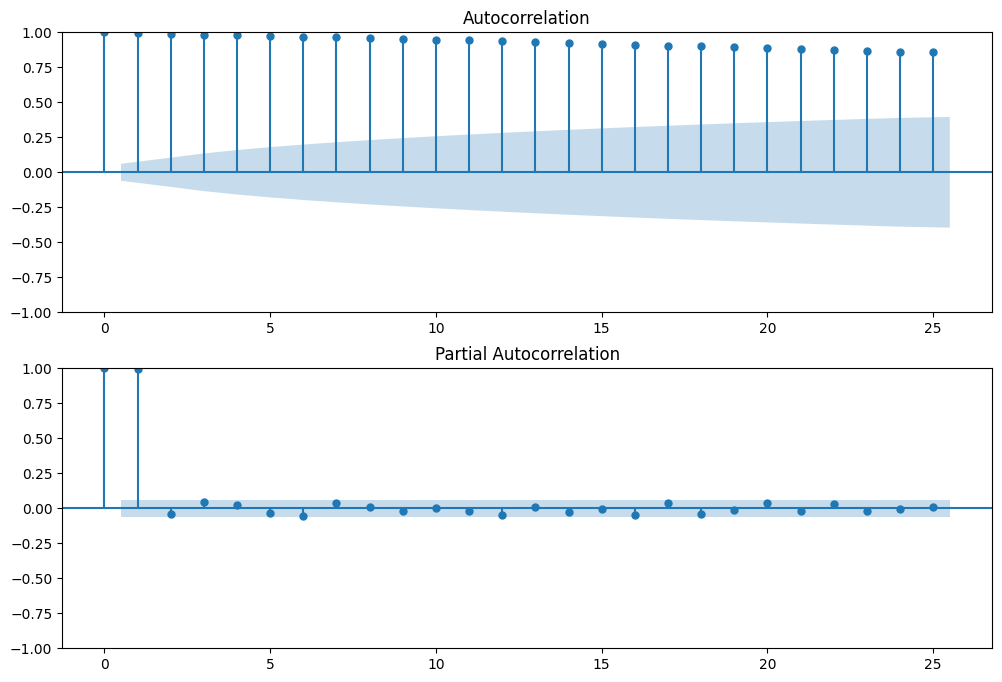

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(imoex.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(imoex, lags=25, ax=ax2)

Значение ряда зависит от предыдущего, значит модель авторегрессии 1 порядка

## Вычитание полиномиального тренда

Ряд стационарный.Отвергаем H0 на уровне знач 0,05.
adf:  -3.6081944323373047
p-value 0.00560628645998357
Critical values:  {'1%': -3.436714730058834, '5%': -2.8643501440982058, '10%': -2.5682662399849185}


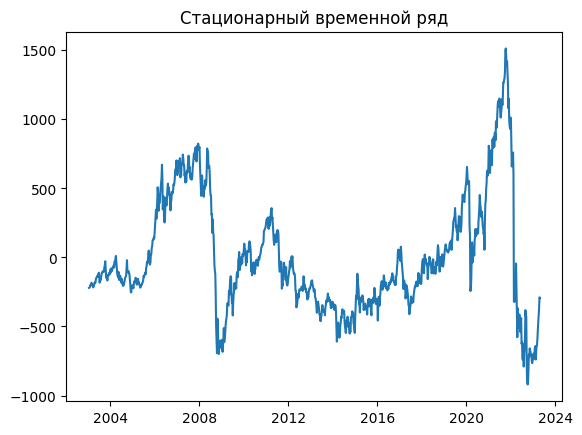

In [ ]:
# вычисление полиномиального тренда с помощью метода polyfit из библиотеки numpy
trend = np.polyfit(df.index.astype(int), df['imoex'], 1)[0] * df.index.astype(int) + np.polyfit(df.index.astype(int), df['imoex'], 1)[1]

# вычитание тренда из исходного временного ряда
stationary_data = df['imoex'] - trend

# проверка стационарности стационарного временного ряда с помощью теста Дики-Фуллера
check_stationarity(stationary_data)

# визуализация стационарного временного ряда
plt.plot(stationary_data)
plt.title('Стационарный временной ряд')
plt.show()

In [ ]:
df['date'] = df.index.astype(int)

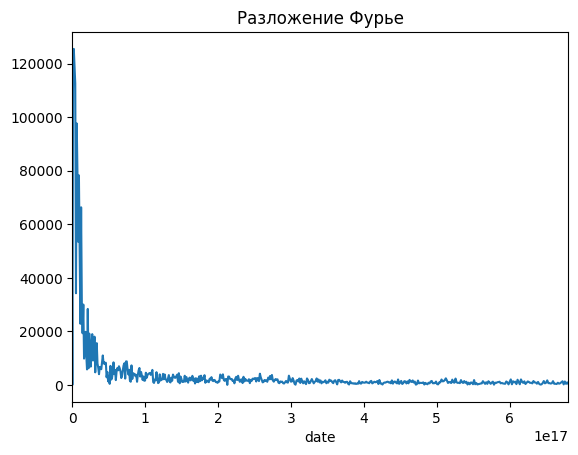

In [ ]:
Y = np.fft.fft(stationary_data)
freqs = np.fft.fftfreq(len(stationary_data), 1/df['date'])
#fig, ax = plt.subplot_mosaic(mosaic = [['left', 'right']], figsize=(20, 8))
sns.lineplot(x=freqs, y=abs(Y)).set(title='Разложение Фурье')
plt.xlim(0, max(freqs))
plt.show()

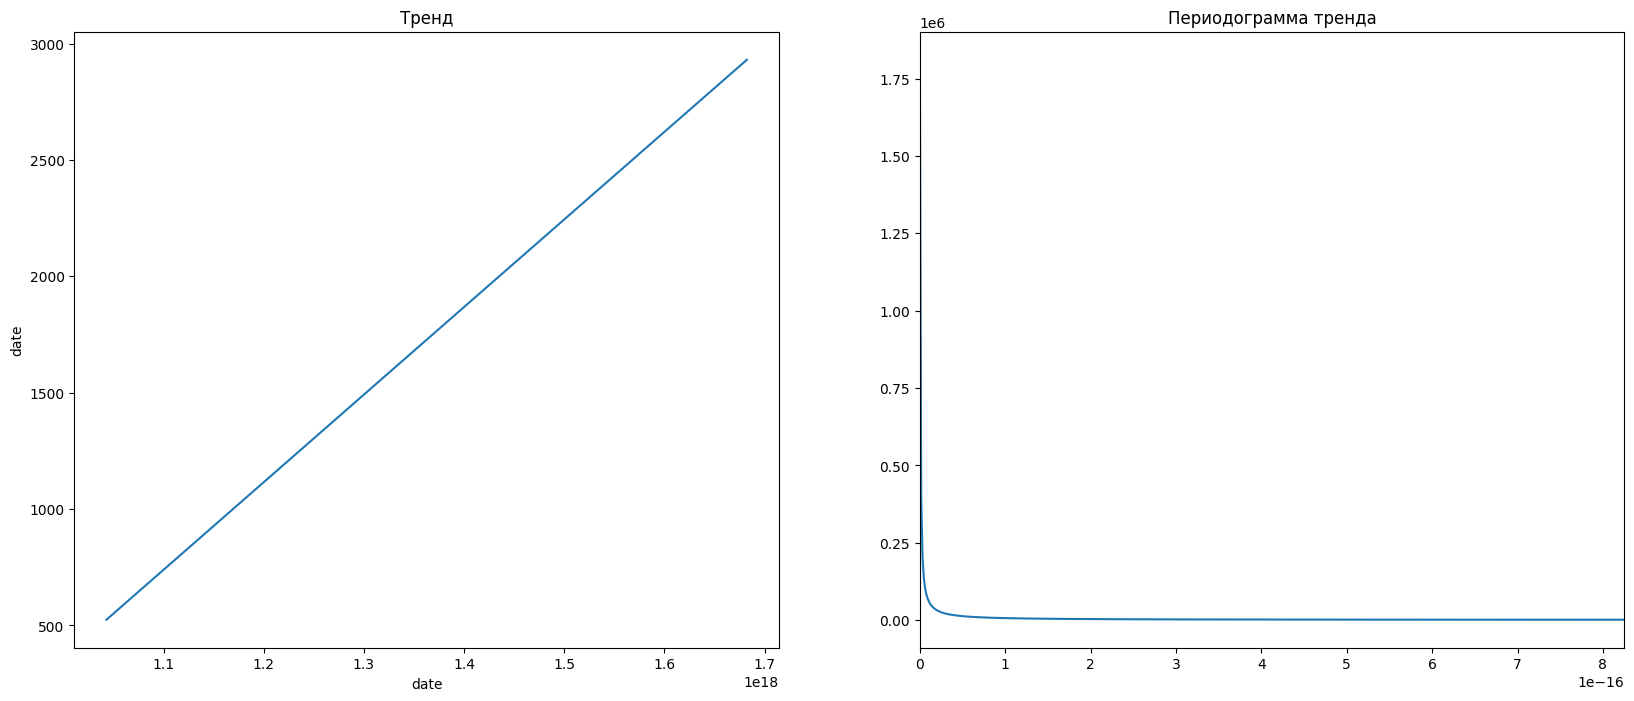

In [ ]:
Y1 = np.fft.fft(trend)
freqs = np.fft.fftfreq(len(trend), df['date'][1] - df['date'][0])
fig, ax = plt.subplot_mosaic(mosaic = [['left', 'right']], figsize=(20, 8))
sns.lineplot(data=df, x=df["date"], y=trend, ax=ax['left']).set(title='Тренд')
sns.lineplot(x=freqs, y=abs(Y1), ax=ax['right']).set(title='Периодограмма тренда')
plt.xlim(0, max(freqs))
plt.show()

### Вейвлет анализ для полиномиального тренда


In [ ]:
import pywt
from pylab import *
from scipy import signal

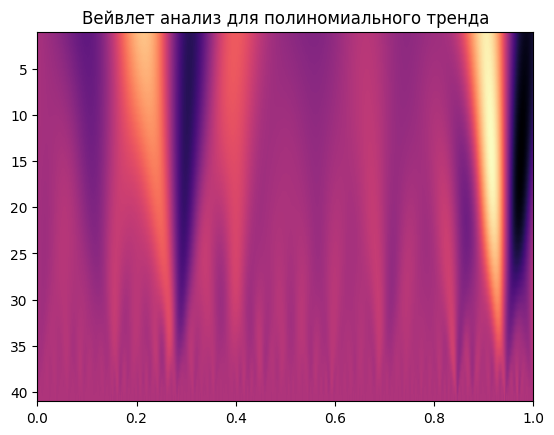

In [ ]:
sig = stationary_data
widths = np.arange(1, 50)
cwtmatr = signal.cwt(sig, signal.ricker, widths)

# строим графики
plt.imshow(cwtmatr, extent=[0, 1, 41, 1], cmap='magma', aspect='auto', origin='lower')
plt.title('Вейвлет анализ для полиномиального тренда')
plt.show()

## EMD

In [ ]:
! pip install emd -q
import emd

/usr/local/lib/python3.10/dist-packages/emd/support.py:228: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]


<Axes: xlabel='Time (samples)'>

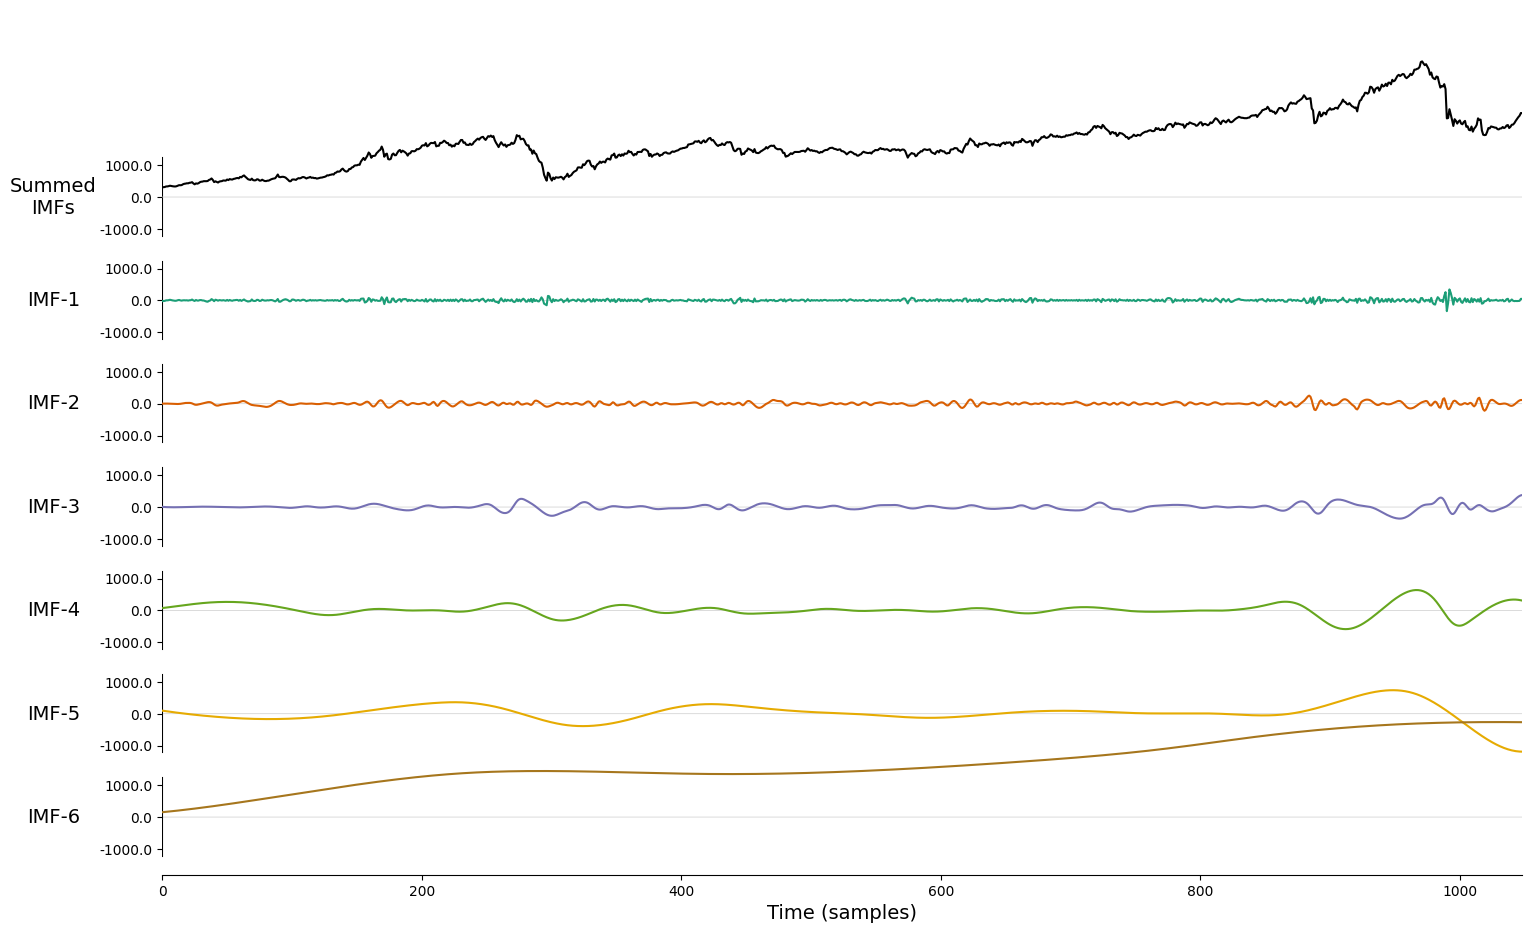

In [ ]:
imf=emd.sift.sift(imoex, max_imfs=6)
emd.plotting.plot_imfs(imf)

первая функция описывает динамику шумовой компоненты, в то время как две последние – тренда. Остальные моды характеризуют изменения во времени циклических колебаний с разной периодичностью.

In [ ]:
imf1=[]
for i in imf:
  imf1.append(i[0])

imf2=[]
for i in imf:
  imf2.append(i[1])

imf3=[]
for i in imf:
  imf3.append(i[2])

imf4=[]
for i in imf:
  imf4.append(i[3])

imf5=[]
for i in imf:
  imf5.append(i[4])

imf6=[]
for i in imf:
  imf6.append(i[5])

new_imf6 =[]
for x in range(len(imoex)):
  z=imoex[x]-imf6[x]
  new_imf6.append(z)

new_imf5 =[]
for x in range(len(imoex)):
  z=imoex[x]-imf5[x] -imf6[x]
  new_imf5.append(z)

new_imf4 =[]
for x in range(len(imoex)):
  z=imoex[x]-imf5[x] - imf4[x]-imf6[x]
  new_imf4.append(z)

new_imf3 =[]
for x in range(len(imoex)):
  z=imoex[x]-imf5[x] - imf4[x]-imf3[x]-imf6[x]
  new_imf3.append(z)

new_imf2 =[]
for x in range(len(imoex)):
  z=imoex[x] -imf5[x] - imf4[x] -imf3[x]-imf2[x]-imf6[x]
  new_imf2.append(z)

new_imf1 =[]
for x in range(len(imoex)):
  z=imoex[x]-imf5[x] - imf4[x]-imf3[x]-imf2[x]-imf1[x]-imf6[x]
  new_imf1.append(z)

In [ ]:
detrend = imoex - imf6 - imf5
df['emd'] = new_imf5
check_stationarity(detrend)

Ряд стационарный.Отвергаем H0 на уровне знач 0,05.
adf:  -5.775280606263505
p-value 5.27705238853012e-07
Critical values:  {'1%': -3.436714730058834, '5%': -2.8643501440982058, '10%': -2.5682662399849185}


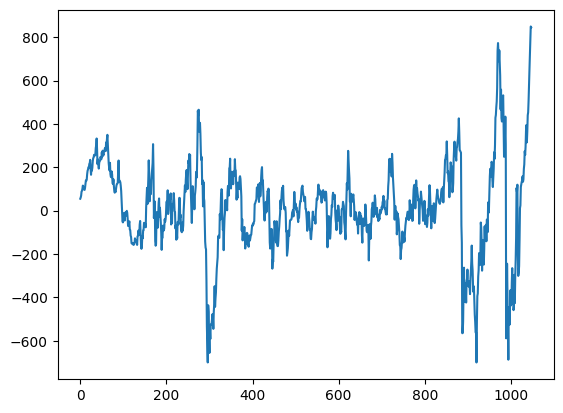

In [ ]:
plt.plot(new_imf5)

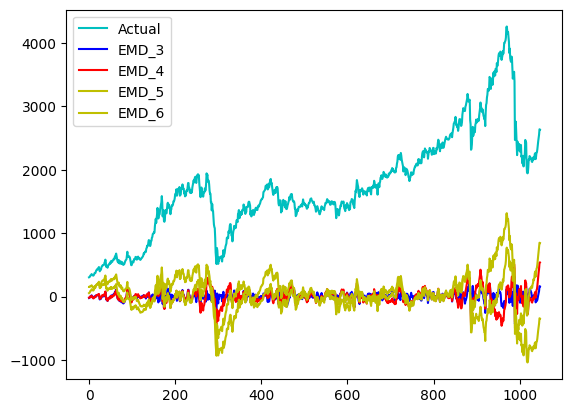

In [ ]:
plt.plot(imoex, "c", label = "Actual")
plt.plot(new_imf3, "b", label = "EMD_3")
plt.plot(new_imf4, "r", label = "EMD_4")
plt.plot(new_imf5, "y", label = "EMD_5")
plt.plot(new_imf6, "y", label = "EMD_6")
plt.legend(loc="best")

### Разложение Фурье по emd


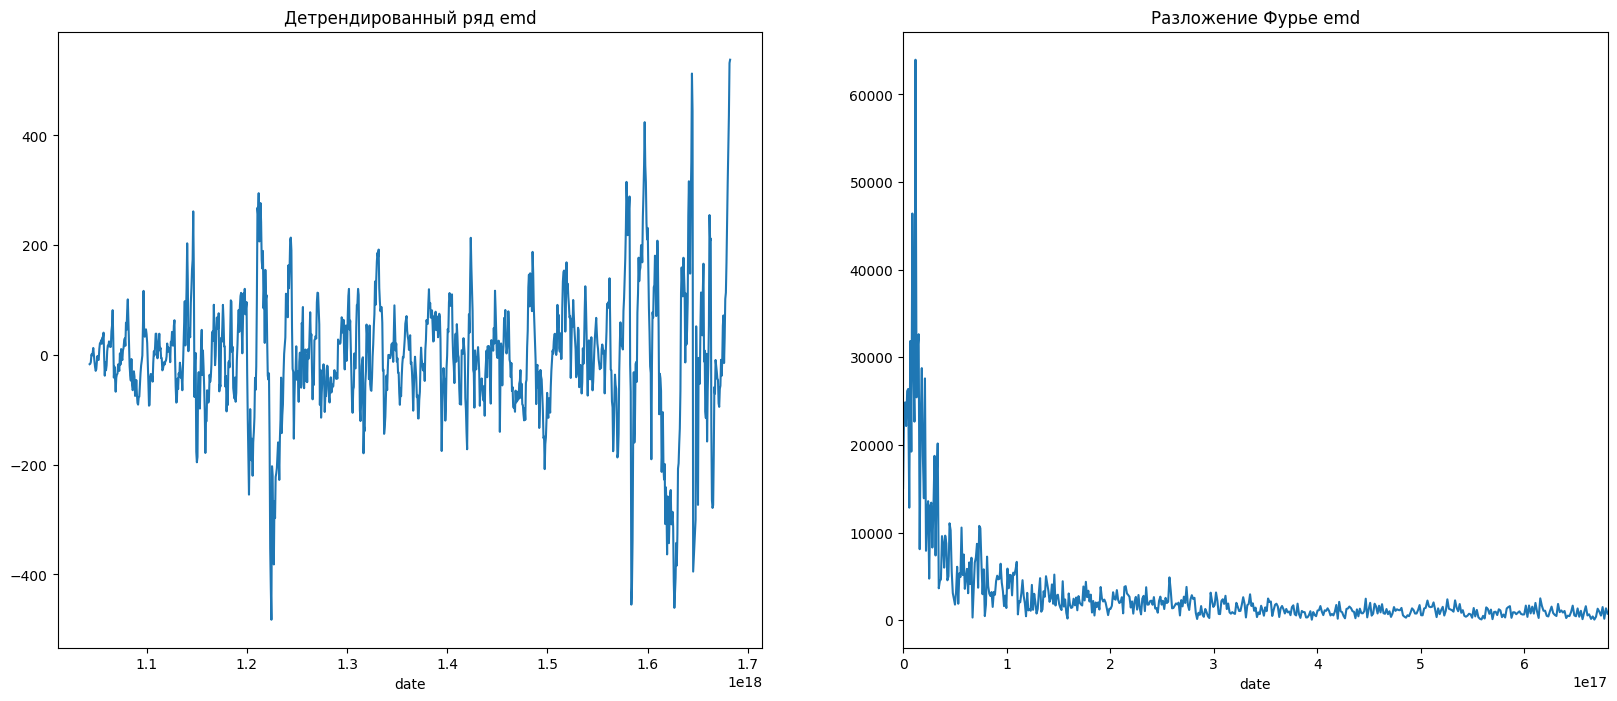

In [ ]:
Y = np.fft.fft(detrend)
freqs = np.fft.fftfreq(len(detrend), 1/df['date'])
fig, ax = plt.subplot_mosaic(mosaic = [['left', 'right']], figsize=(20, 8))
sns.lineplot(data=df, x=df["date"], y=new_imf4, ax=ax['left']).set(title='Детрендированный ряд emd')
sns.lineplot(x=freqs, y=abs(Y), ax=ax['right']).set(title='Разложение Фурье emd')
plt.xlim(0, max(freqs))
plt.show()

В тренде присутствуют в основном низкие частоты, что хорошо

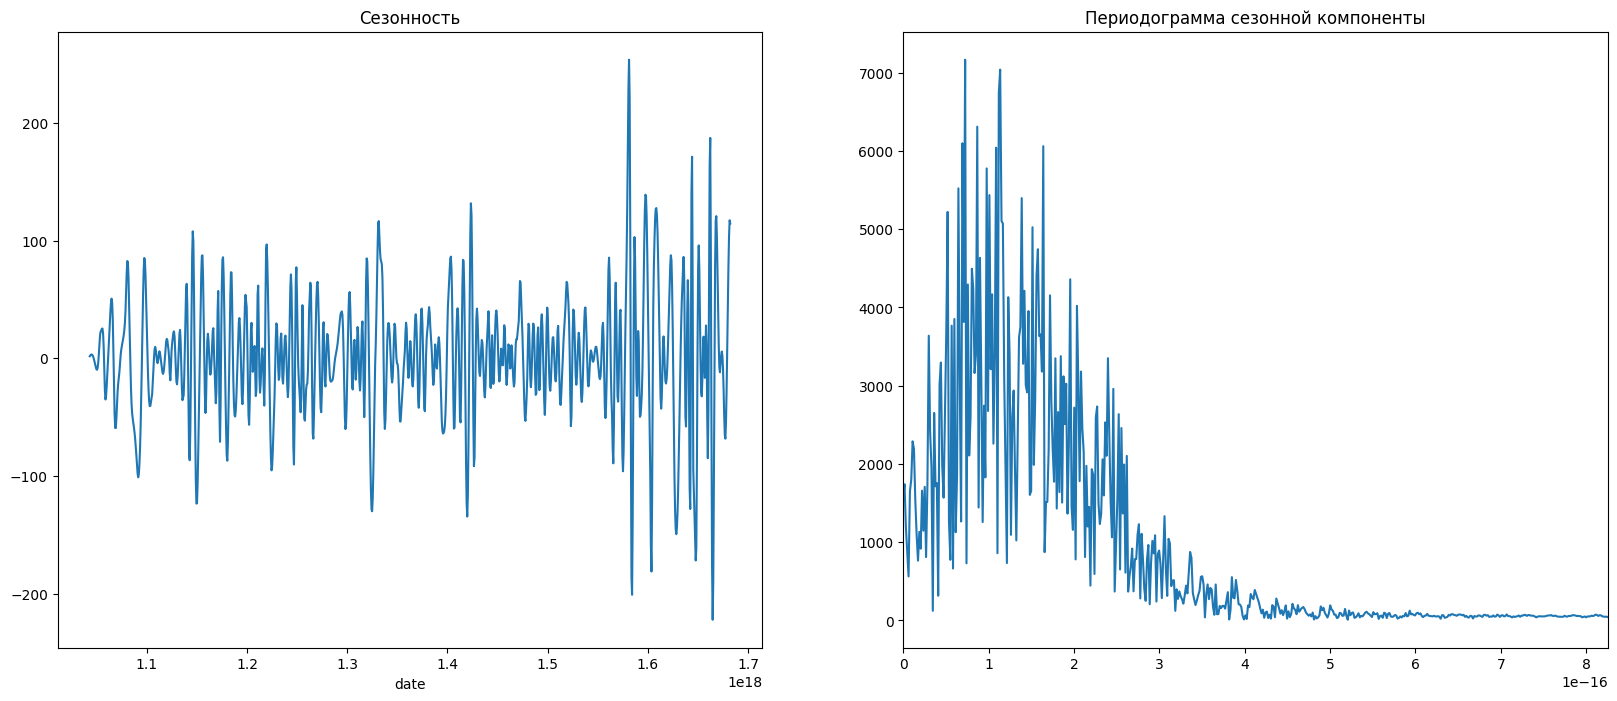

In [ ]:
season = imf2
Y1 = np.fft.fft(season)
freqs = np.fft.fftfreq(len(season), df['date'][1] - df['date'][0])
fig, ax = plt.subplot_mosaic(mosaic = [['left', 'right']], figsize=(20, 8))
sns.lineplot(data=df, x=df["date"], y=season, ax=ax['left']).set(title='Сезонность')
sns.lineplot(x=freqs, y=abs(Y1), ax=ax['right']).set(title='Периодограмма сезонной компоненты')
plt.xlim(0, max(freqs))
plt.show()

По сезонной компоненте тяжело что либо сказать, но если сезонность есть, то скорее с периодичностью в год-полгода.

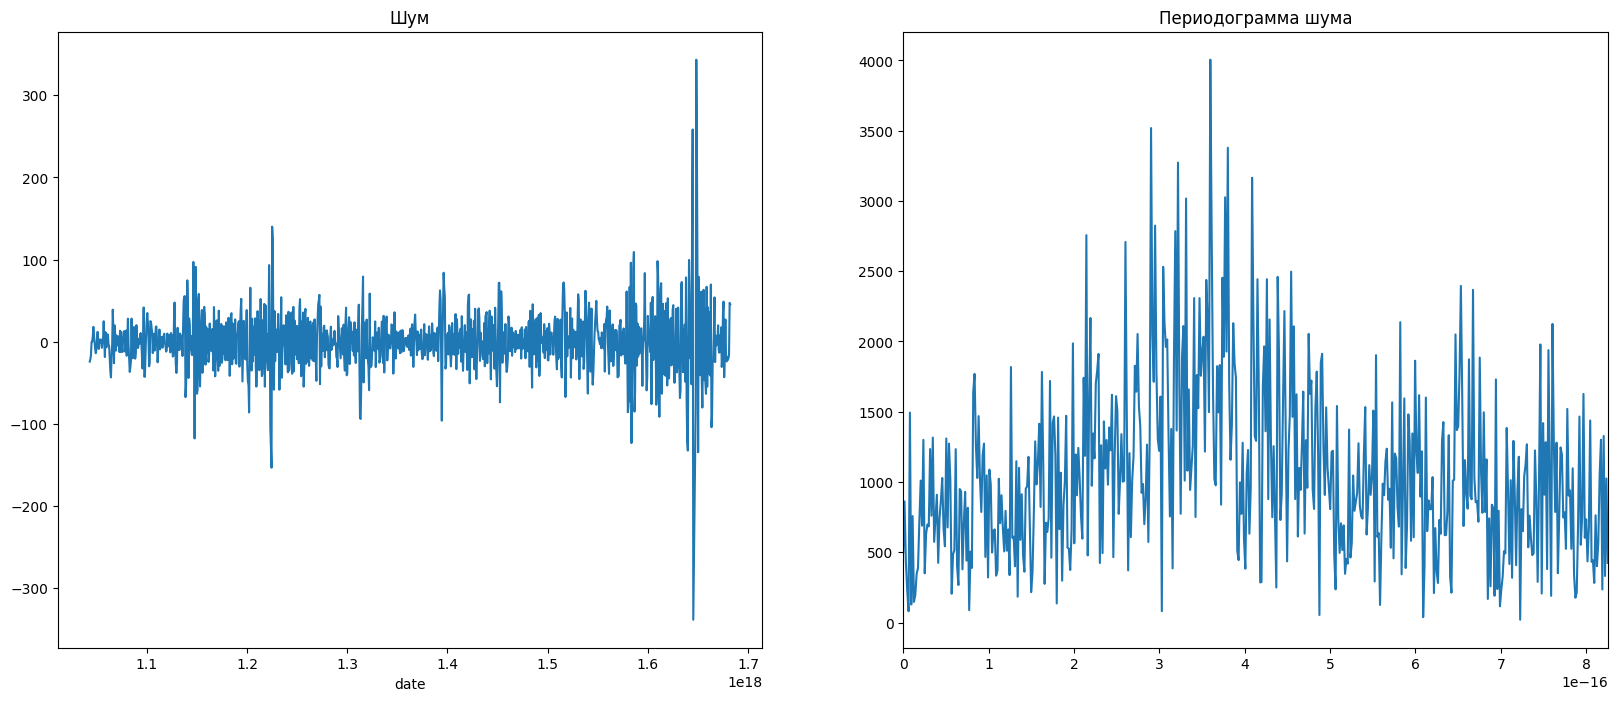

In [ ]:
random = imf1
Y1 = np.fft.fft(random)
freqs = np.fft.fftfreq(len(random), df['date'][1] - df['date'][0])
fig, ax = plt.subplot_mosaic(mosaic = [['left', 'right']], figsize=(20, 8))
sns.lineplot(data=df, x=df["date"], y=random, ax=ax['left']).set(title='Шум')
sns.lineplot(x=freqs, y=abs(Y1), ax=ax['right']).set(title='Периодограмма шума')
plt.xlim(0, max(freqs))
plt.show()

Так как для шума вообще нет детерминирующих частот, мы видим из периодограммы, что каждая частота входит примерно с одинаковой силой. Шум поход на случайную величину. По виду можем сказать, что шум выделился правильно

### Вейвлет анализ для emd

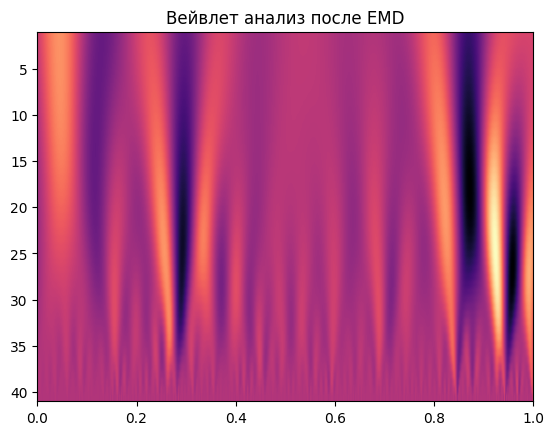

In [ ]:
sig = imoex - imf6 - imf5
widths = np.arange(1, 50)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
plt.imshow(cwtmatr, extent=[0, 1, 41, 1], cmap='magma', aspect='auto', origin='lower')
plt.title('Вейвлет анализ после EMD') ;

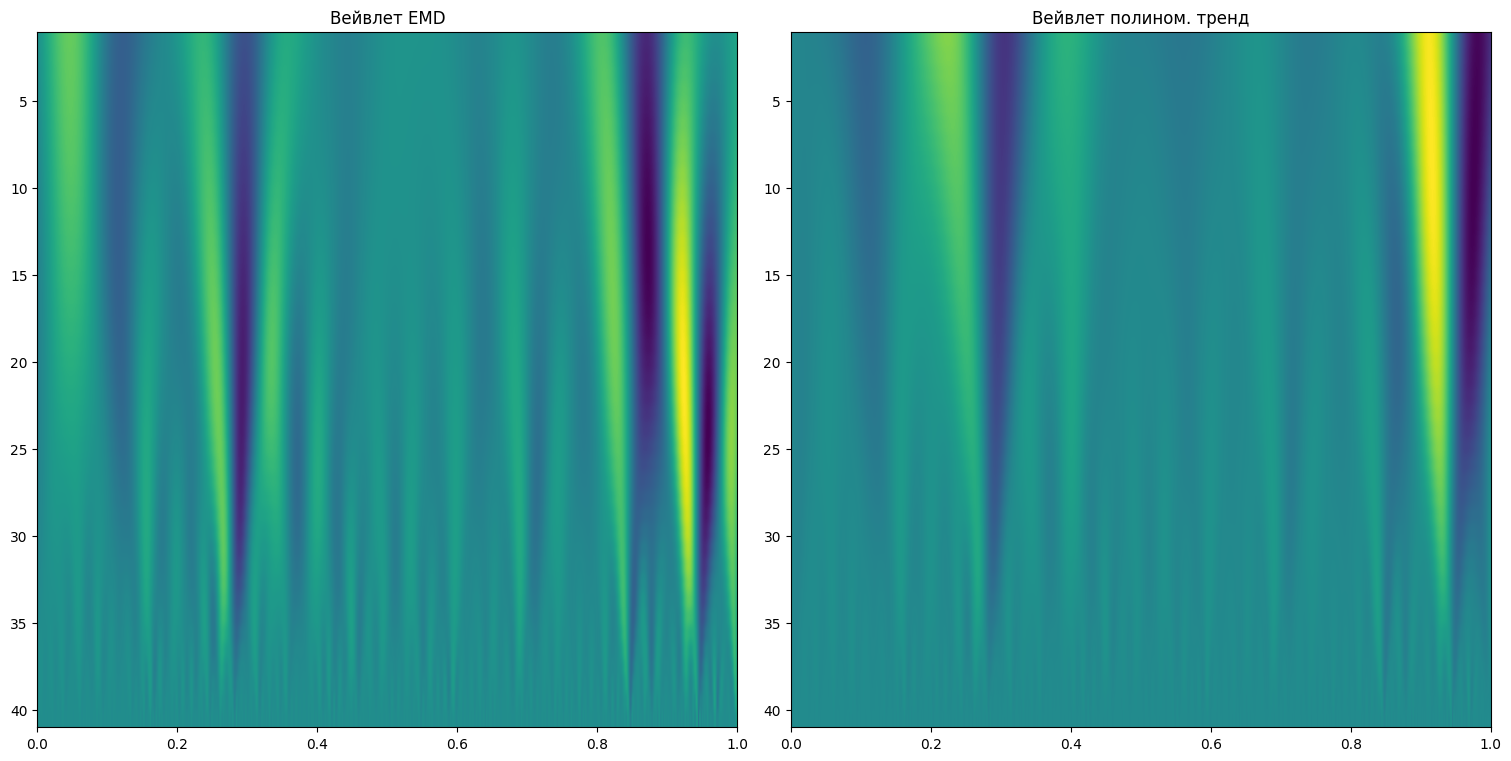

In [ ]:
emd_detrend = imoex - imf6 - imf5
fig, axes = plt.subplot_mosaic([['left', 'right']],
                                figsize=(15, 7.5), layout="constrained")

sig = emd_detrend
widths = np.arange(1, 42)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
axes['left'].imshow(cwtmatr, extent=[0, 1, 41, 1], aspect='auto', origin='lower')
axes['left'].set_title('Вейвлет EMD')


sig = stationary_data
widths = np.arange(1, 42)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
axes['right'].imshow(cwtmatr, extent=[0, 1, 41, 1], aspect='auto', origin='lower')
axes['right'].set_title('Вейвлет полином. тренд')

plt.show()


- Вертикальные полосы указывают на импульсы или скачки.
- Основные частоты 0.3 и  0.9
-

In [ ]:
! pip install scaleogram -q
import scaleogram as scg

In [ ]:
scg.set_default_wavelet('cmor1-1.5')

-


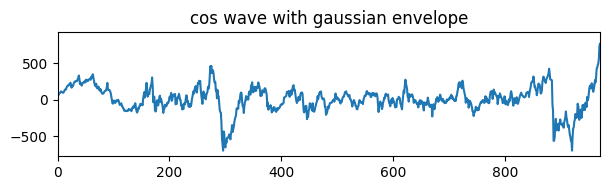

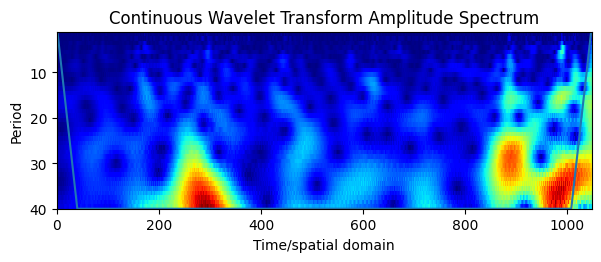

In [ ]:
ns   = 970
time = np.arange(ns)

# and a range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, 40) )

fig1, ax1 = plt.subplots(1, 1, figsize=(6.2,2));
lines = ax1.plot(emd_detrend);
ax1.set_xlim(0, len(time))
ax1.set_title("cos wave with gaussian envelope")
fig1.tight_layout()
try:
# and the scaleogram
  ax2 = scg.cws(emd_detrend, scales=scales, figsize=(6.9,2.3));
  txt = ax2.annotate("p1=10s", xy=(100, 10), bbox=dict(boxstyle="round4", fc="w"))
  plt.tight_layout()

except TypeError as e:
  if "alpha must be numeric or None, not a string" in str(e):
    print("-")

In [ ]:
df['polinom'] = stationary_data

In [ ]:
df.to_excel('imoex_stationary.xlsx')

In [ ]:
df

,imoex,Unnamed: 2,date,emd,polinom
date,,,,,
2003-01-20,303.97,NaN,1043020800000000000,55.027545,-220.696101
2003-01-27,307.78,1.012534,1043625600000000000,60.722430,-219.162578
2003-02-03,314.34,1.034115,1044230400000000000,69.060300,-214.879055
2003-02-10,331.69,1.091193,1044835200000000000,88.081417,-199.805533
2003-02-17,333.42,1.096885,1045440000000000000,91.376042,-200.352010
...,...,...,...,...,...
2023-03-27,2450.67,8.062210,1679875200000000000,649.129485,-471.126569
2023-04-03,2508.39,8.252097,1680480000000000000,711.677111,-415.683046
2023-04-10,2554.85,8.404941,1681084800000000000,761.814175,-371.499523
